In [ ]:
### we should do pip install

In [4]:
import gym
import gym_Rubiks_Cube

from flax import optim
import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax, numpy as jnp
from jax import vmap, jit
import jax.random as jrandom

from flax import optim
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn

import optax
import numpy as np

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

import collections

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'gym_Rubiks_Cube'

In [3]:
env = gym.make("RubiksCube-v0")
env.setScramble(0, 1, False)
obs, done = env.reset(), True
env.step(1)
env.step(7)
env.render("human")

          +  +  +                   
          +  +  +                   
          +  +  +                   
 +  +  +  +  +  +  +  +  +  +  +  + 
 +  +  +  +  +  +  +  +  +  +  +  + 
 +  +  +  +  +  +  +  +  +  +  +  + 
          +  +  +                   
          +  +  +                   
          +  +  +                   



In [4]:
obs

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4])

### Mains functions for training

In [ ]:
## First we can try to solve it using "classic machine learning"
## conversion action => on hot encoder

from flax import linen as nn

class Model_rubik(nn.Module):

    features = (4096, 2048, 512, 12)

    def setup(self):
        self.dense1 = nn.Dense(self.features[0])
        self.dense2 = nn.Dense(self.features[1])
        self.dense3 = nn.Dense(self.features[2])
        self.dense4 = nn.Dense(self.features[3])

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = nn.relu(self.dense3(x))
        x = self.dense4(x)
        return nn.softmax(x)

model_rubik = Model_rubik()
    
key1, key2 = jrandom.split(jrandom.PRNGKey(0))
x = jrandom.normal(key1, (54*6,)) # Dummy input
params = model_rubik.init(key2, x) # Initialization call
    
#### action help
def encoder_one_hot_action(action):
    """
    Encode the action into a one hot encoder vector
    """
    
    action_encode = jnp.zeros(12)
    action_encode = jax.ops.index_update(action_encode, jax.ops.index[action], 1)

    return action_encode

def encoder_decode_action(action_encode):
    """
    Decode from one hot to int value
    """
    action = jnp.argmax(action_encode)
    
    return action

#### state help
def encoder_one_hot_state(state):
    """
    Encode the action into a one hot encoder vector
    """
    
    state_encode = jnp.zeros((54, 6))
    
    for idx, i in enumerate(state):
        state_encode = jax.ops.index_update(state_encode, jax.ops.index[idx, i], 1)

    return jnp.ravel(state_encode), state_encode

def encoder_decode_state(state_encode):
    """
    Decode from one hot to int value
    """
    state = jnp.argmax(state_encode, axis=1)
    
    return state

def compute_inverse_action(action):
    return (action + 6) % 12

reverse_list = vmap(compute_inverse_action)

encoder_one_hot_action_action = vmap(encoder_one_hot_action)
encoder_one_hot_state_vector = vmap(encoder_one_hot_state)

nb_iter = 15

def compute_random_suffle(dumpy_value):
    
    env = gym.make("RubiksCube-v0")
    env.setScramble(0, 1, False)
    obs, done = env.reset(), False
    episode_rew = 0
    
    ## action list
    #actions = jrandom.randint(key1, shape=(nb_iter,1), minval=0, maxval=12)
    actions = np.random.randint(0, 12, size=(nb_iter,1))
    
    ## state list
    obs_list = []
    
    for _ in range(nb_iter):
        
        obs, rew, done, _ = env.step(actions[_, 0])
        obs_list.append(obs)
        
        ## we should also compute the max of the model
    
    ### we compute the reverse action
    
    return jnp.array(obs_list), reverse_list(actions)

def make_cross_entropy_loss(x_batched, y_batched):
    def cel(params):
        # Define the squared loss for a single pair (x,y)
        def cross_entropy_loss(x, y):
            pred = model_rubik.apply(params, x)
            return -jnp.inner(y, jnp.log(pred))/2.0
        
        # We vectorize the previous to compute the average of the loss on all samples.
        return jnp.mean(jax.vmap(cross_entropy_loss)(x_batched,y_batched), axis=0)
    return jax.jit(cel) # And finally we jit the result.




### Testing part

In [6]:
%%time
## testing results
encode_vector = encoder_one_hot_action(0)
encoder_decode_action(encode_vector)

encoded, encoded_hot = encoder_one_hot_state(obs)
encoder_decode_state(encoded_hot)

## computer result
for i in range(1):
    list_obs, actions = compute_random_suffle(0)

CPU times: user 275 ms, sys: 31.7 ms, total: 307 ms
Wall time: 264 ms


In [3]:
### Now we try to compute the solution 
### we generate a list of target
%time list_obs, actions = compute_random_suffle(0)

NameError: name 'compute_random_suffle' is not defined

### 1. Little loop (self supervised)

In [ ]:
%%time
### for loop
# 1. loop on epoch
# In loop generate sample
# train on generated sample (batch)
nb_iter_main_loop = 10000


optimizer_def = optim.Adam(learning_rate=0.001) # Choose the method
optimizer = optimizer_def.create(params) # Create the wrapping optimizer with initial parameters

for _ in range(nb_iter_main_loop):
    
    # train on main loop
    list_obs, actions = compute_random_suffle(0)

    # process for training
    actions = encoder_one_hot_action_action(actions)
    list_obs, list_obs_encode = encoder_one_hot_state_vector(list_obs)
    
    # loss define
    loss = make_cross_entropy_loss(list_obs, actions)
    loss_grad_fn = jax.value_and_grad(loss)
    
    # optimizer application
    loss_val, grad = loss_grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad) # Return the updated optimizer with parameters.
    

### 2. First make the dataset and then we train it on the loop

#### 2.1 create dataset

In [7]:
%%time
### Plan : generate 2m6 datapoints and then train it on 1m6 and then compute the result on the other 1m6

def generate_dataset(nb_iter_main_loop=1000):

    actions_all = []
    obs_all = []

    for _ in range(nb_iter_main_loop):

        # train on main loop
        list_obs, actions = compute_random_suffle(0)

        # process for training
        actions = encoder_one_hot_action_action(actions)
        list_obs, list_obs_encode = encoder_one_hot_state_vector(list_obs)

        actions_all.append(actions)
        obs_all.append(list_obs)
        
    obs_all = jnp.concatenate(obs_all)
    actions_all = jnp.concatenate(actions_all)
        
    return obs_all, actions_all


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


#### 2.2 Loader construction

In [9]:


obs_all, actions_all = generate_dataset()

dataset = TensorDataset(torch.from_numpy(np.array(obs_all)), torch.from_numpy(np.array(actions_all)))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


#### 2.3 Optimization

In [100]:
loss_hist = []

optimizer_def = optim.GradientDescent(learning_rate=0.01) # Choose the method

optimizer = optimizer_def.create(params) # Create the wrapping optimizer with initial parameters

nb_epoch = 1

def make_cross_entropy_loss_second(params_, x, y):
    pred = model_rubik.apply(params_, x)
    loss = -jnp.inner(y, jnp.log(pred))/2.0
    return loss

cross_entropy_loss_second = vmap(make_cross_entropy_loss_second, in_axes=(None, 0, 0))

def cross_entropy_loss_second_scalar(params, x, y):
    return jnp.mean(cross_entropy_loss_second(params, x, y))

jit_cross_entropy_loss_second_scalar = jit(cross_entropy_loss_second_scalar)

for _ in range(nb_epoch):
    for obs, actions in dataloader:

        obs = jnp.array(obs)
        actions = jnp.array(actions)

        # loss define
        loss_grad_fn = jax.value_and_grad(jit_cross_entropy_loss_second_scalar, argnums=0)

        # optimizer application
        loss_val, grad = loss_grad_fn(optimizer.target, obs, actions)
        optimizer = optimizer.apply_gradient(grad) # Return the updated optimizer with parameters.
        
        # save for plot
        loss_hist.append(loss_val)
        
        

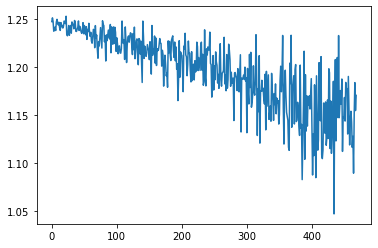

In [99]:
plt.plot(loss_hist)

#### 2.4 Optimization with Optax

In [8]:
loss_hist = []

optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

nb_epoch = 3
nb_round_generation = 10

def make_cross_entropy_loss_second(params_, x, y):
    pred = model_rubik.apply(params_, x)
    loss = -jnp.inner(y, jnp.log(pred))/2.0
    return loss

cross_entropy_loss_second = vmap(make_cross_entropy_loss_second, in_axes=(None, 0, 0))

def cross_entropy_loss_second_scalar(params, x, y):
    return jnp.mean(cross_entropy_loss_second(params, x, y))

jit_cross_entropy_loss_second_scalar = jit(cross_entropy_loss_second_scalar)

for _ in range(nb_round_generation):

    print("New generation")
    
    obs_all, actions_all = generate_dataset()

    dataset = TensorDataset(torch.from_numpy(np.array(obs_all)), torch.from_numpy(np.array(actions_all)))
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    for _ in range(nb_epoch):
        
        for obs, actions in dataloader:

            obs = jnp.array(obs)
            actions = jnp.array(actions)

            # loss define
            loss_grad_fn = jax.value_and_grad(jit_cross_entropy_loss_second_scalar, argnums=0)

            # optimizer application
            loss_val, grad = loss_grad_fn(params, obs, actions)

            updates, opt_state = optimizer.update(grad, opt_state, params)  # transform & update stats.
            params = optax.apply_updates(params, updates)

            # save for plot
            loss_hist.append(loss_val)
        

New generation
New generation
New generation
New generation
New generation
New generation
New generation
New generation
New generation
New generation


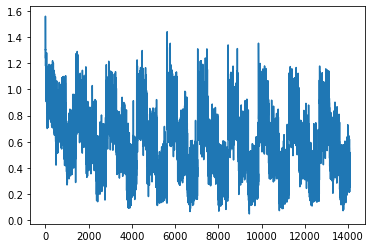

In [9]:
plt.plot(loss_hist)

[ScaleByAdamState(count=DeviceArray(0, dtype=int32), mu=FrozenDict({
     params: {
         dense1: {
             bias: DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
             kernel: DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
         },
         dense2: {
             bias: DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
             kernel: DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0

In [82]:
loss = -jnp.inner(actions[0,:], jnp.log(pred))/2.0

In [ ]:
loss_hist